The aim of this notebook is to use PCA to explore whether there is a difference between the animal and non-animal dataset somewhere in the activations of LLama 7B 2 chat, and to identify where this difference is. 

In [1]:
import numpy as np
import random
import pandas as pd
import torch as t
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

 

def process_sentences(sentences, model, layer_names, tokenizer, max_length, device='cuda', batch_size=4):
    all_activations = []
    all_last_tokens = []

    for i in range(0, len(sentences), batch_size):
        
        t.cuda.empty_cache()  # Clear unused memory

        print(f"Processing batch {i // batch_size + 1}/{len(sentences) // batch_size + 1}")
        print(f"Allocated: {torch.cuda.memory_allocated()}")
        print(f"Reserved:  {torch.cuda.memory_reserved()}")

        batch_sentences = sentences[i:i + batch_size]
        if not batch_sentences:
            continue  # Skip empty batch

        assert all(isinstance(sent, str) for sent in batch_sentences), "All items in batch_sentences must be of type str"

        if max_length is None:
            batch_max_length = min(max(len(tokenizer.tokenize(sent)) for sent in batch_sentences), 512)
            inputs = tokenizer(batch_sentences, max_length=batch_max_length, padding='max_length', truncation=True, return_tensors="pt")
        else:
            inputs = tokenizer(batch_sentences, max_length=max_length, padding='max_length', truncation=True, return_tensors="pt")

        inputs = {key: val.to(device) for key, val in inputs.items()}

        activations = {}
        def get_activation(name):
            def hook(model, input, output):
                activations[name] = output[0].detach().cpu()
            return hook

        hook_handles = []
        for j, layer in enumerate(model.model.layers):
            if f'Decoder_Layer_{j}' in layer_names:
                handle = layer.register_forward_hook(get_activation(f'Decoder_Layer_{j}'))
                hook_handles.append(handle)

        with torch.no_grad():
            outputs = model(**inputs)

        for handle in hook_handles:
            handle.remove()

        all_activations.append(activations)
        last_token_indices = (inputs['attention_mask'].sum(dim=1) - 1).tolist()
        all_last_tokens.extend(last_token_indices)

    if all_activations:  # Check if the list is not empty
        combined_activations = {key: torch.cat([batch[key] for batch in all_activations], dim=0) for key in all_activations[0]}
    else:
        print("Warning: No activations collected. Returning empty structures.")
        combined_activations = {}

    return combined_activations, all_last_tokens




In [3]:
# Load the CSV file to verify it
df_sentences = pd.read_csv('../datasets/hc_dataset_llama.csv')

# Display the first few entries
print(df_sentences.head())

# Filter the DataFrame for rows where the Label column is 'Animal'
animal_sentences = df_sentences[df_sentences['Label'] == 'Animal']['Sentence'].tolist()
non_animal_sentences = df_sentences[df_sentences['Label'] == 'Non-Animal']['Sentence'].tolist()

print(len(df_sentences))


    Label                                           Sentence
0  Animal  \n<s>[INST] <<SYS>>\nYou are a helpful, respec...
1  Animal  \n<s>[INST] <<SYS>>\nYou are a helpful, respec...
2  Animal  \n<s>[INST] <<SYS>>\nYou are a helpful, respec...
3  Animal  \n<s>[INST] <<SYS>>\nYou are a helpful, respec...
4  Animal  \n<s>[INST] <<SYS>>\nYou are a helpful, respec...
1232


In [4]:
# Initialize the tokenizer and model #huggingface-cli login
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-chat-hf")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-2-7b-chat-hf")

# Set the EOS token as the padding token if it's not already set
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Check if CUDA is available and set the model to use GPU
device = t.device("cuda" if t.cuda.is_available() else "cpu")
model = model.half()
model.to(device)
print("Using device:", device)
_ = model.eval()

Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.39s/it]


Using device: cuda


In [5]:
# Print max number of layers and max number of tokens
print(f"Number of layers = {len(model.model.layers)}")
max_tokens = tokenizer(df_sentences['Sentence'].tolist(), return_tensors="pt", padding=True, truncation=True, max_length=None)['input_ids'].shape[-1]
print(f"Number of tokens = {max_tokens}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Number of layers = 32
Number of tokens = 916


Processing batch 1/17
Allocated: 13543956480
Reserved:  13545504768
Processing batch 2/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 3/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 4/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 5/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 6/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 7/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 8/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 9/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 10/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 11/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 12/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 13/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 14/17
Allocated: 18384432128
Reserved:  18392023040
Processing batch 15/17
Allocated: 183844321

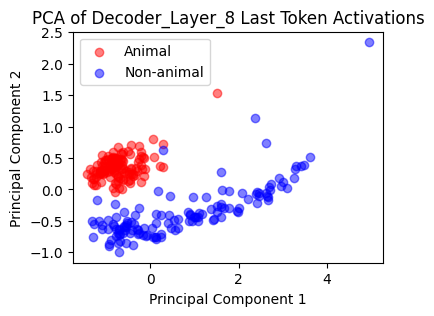

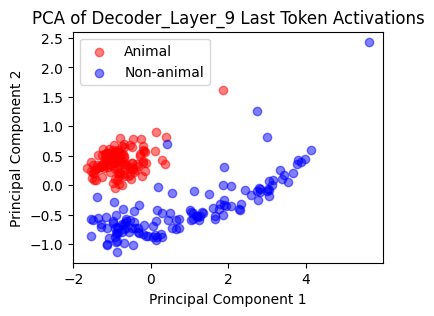

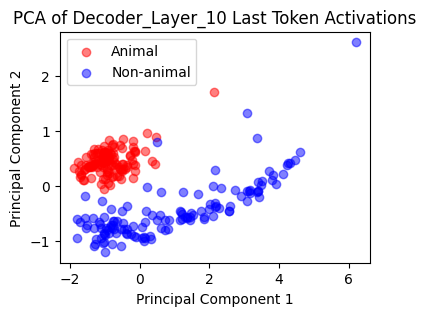

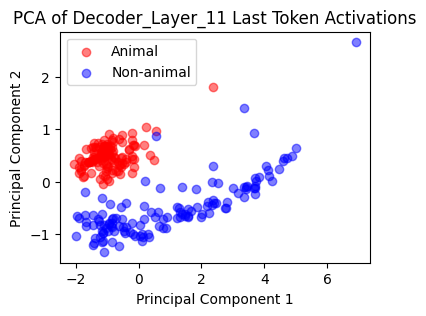

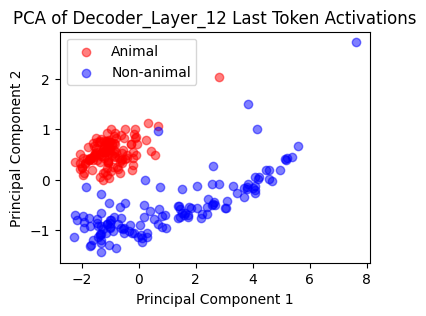

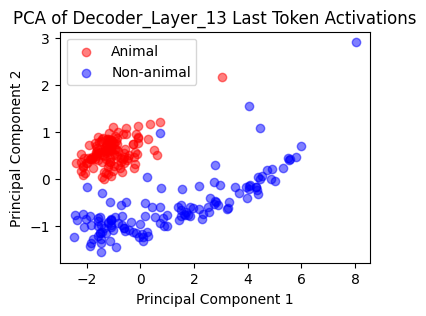

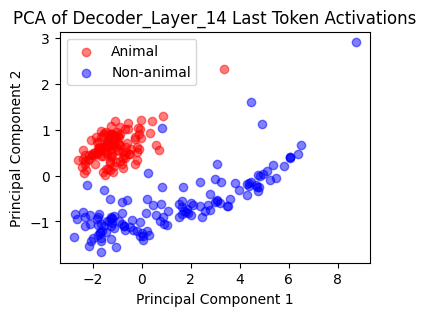

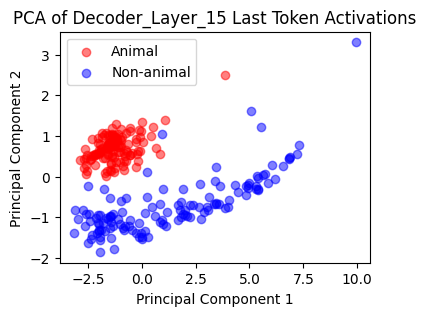

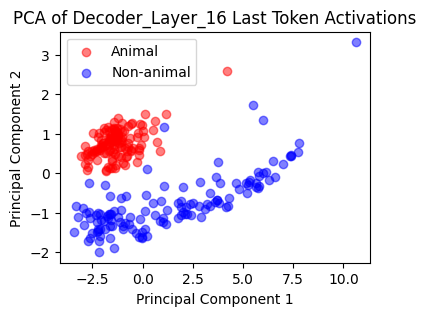

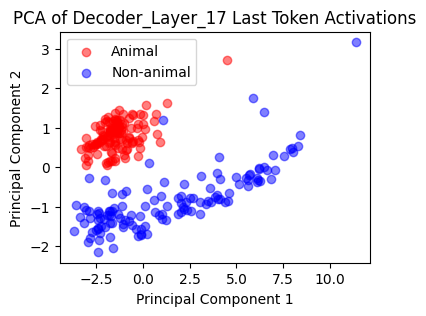

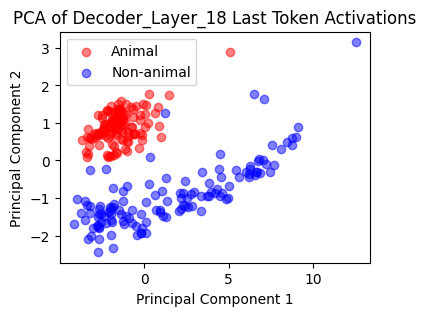

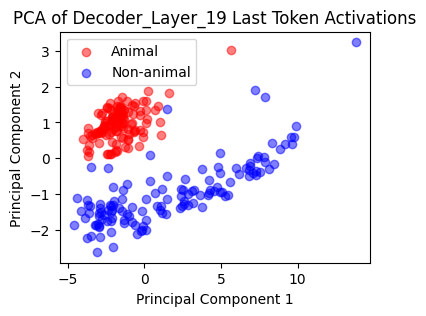

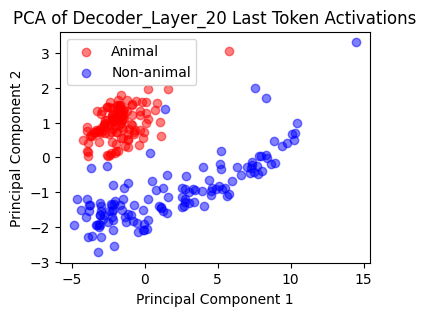

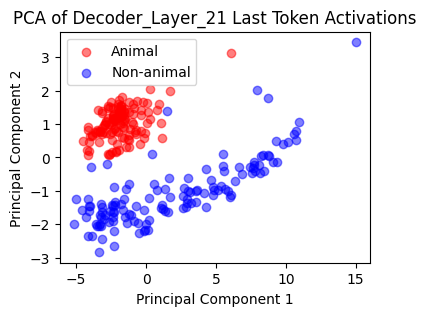

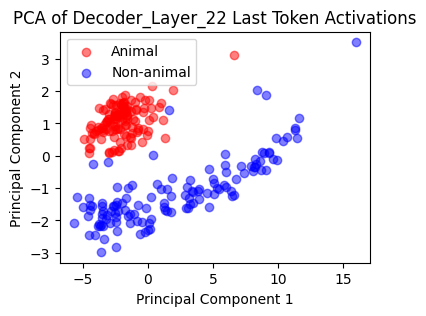

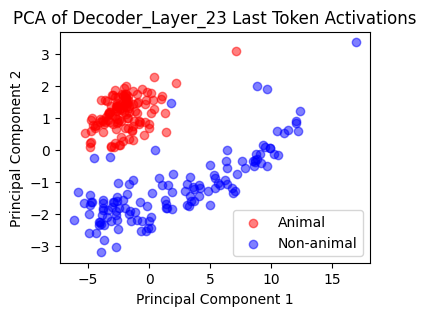

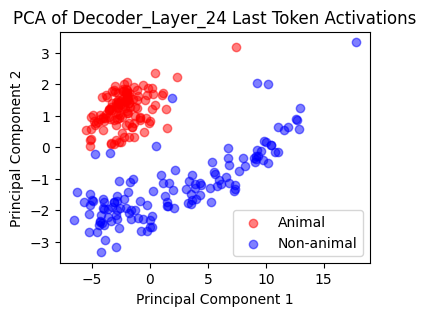

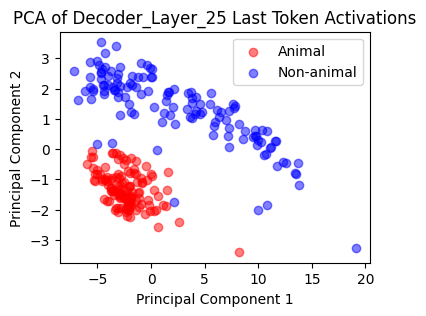

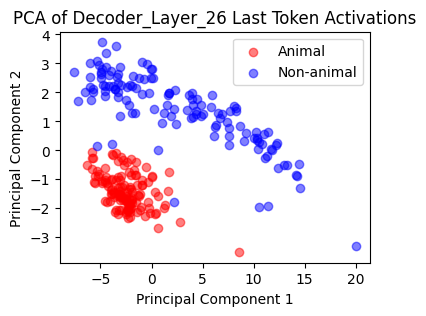

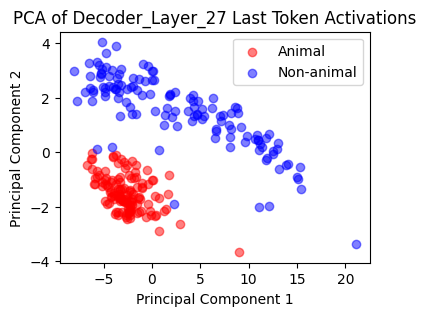

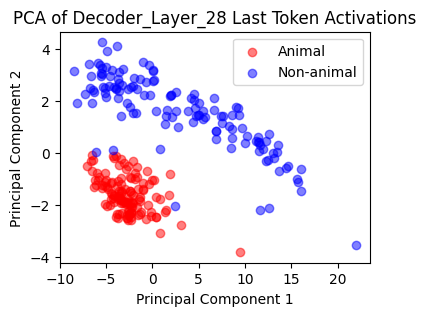

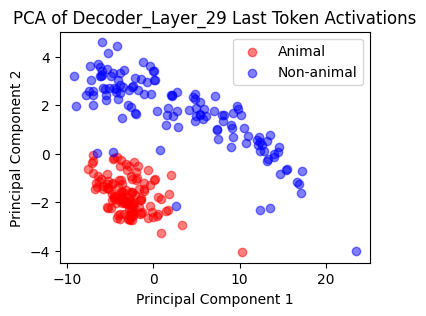

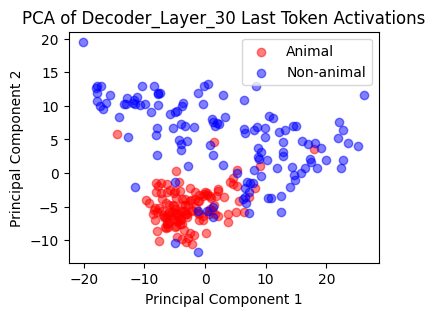

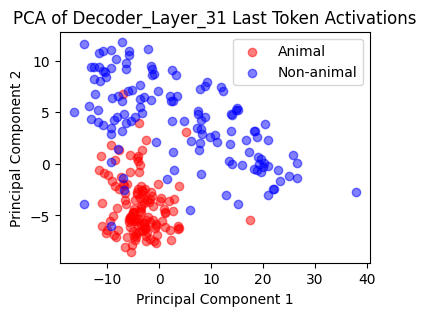

In [6]:
t.cuda.empty_cache()  # Clear unused memory

num_samples = 128
batch_size = 8
layer_names = ['Decoder_Layer_{}'.format(i) for i in range(8,32)]  # All layers

# Max length of sentence for truncation
max_length = 916

# Shuffle sentences
random.shuffle(animal_sentences)
random.shuffle(non_animal_sentences)

# Get activations and last token indices
animal_activations, animal_last_tokens = process_sentences(animal_sentences[0:num_samples], model, layer_names, tokenizer, max_length, device, batch_size)
non_animal_activations, non_animal_last_tokens = process_sentences(non_animal_sentences[0:num_samples], model, layer_names, tokenizer, max_length, device, batch_size)

print("done processing")

# Loop over each layer
for layer_name in layer_names:
    try:
        t.cuda.empty_cache()  # Clear unused memory
        
        # Extract activations for the last token of each sentence
        animal_activations_layer_token = np.array([animal_activations[layer_name][i, idx, :].cpu().numpy() for i, idx in enumerate(animal_last_tokens)])
        non_animal_activations_layer_token = np.array([non_animal_activations[layer_name][i, idx, :].cpu().numpy() for i, idx in enumerate(non_animal_last_tokens)])

        # Combine datasets
        combined_activations = np.vstack((animal_activations_layer_token, non_animal_activations_layer_token))
        labels = np.array([0] * len(animal_activations_layer_token) + [1] * len(non_animal_activations_layer_token))
        
        # Perform PCA
        pca = PCA(n_components=2)  # 2D for easy plotting
        reduced_activations = pca.fit_transform(combined_activations)
        
        # Plotting
        plt.figure(figsize=(4, 3))
        plt.scatter(reduced_activations[labels == 0, 0], reduced_activations[labels == 0, 1], c='red', label='Animal', alpha=0.5)
        plt.scatter(reduced_activations[labels == 1, 0], reduced_activations[labels == 1, 1], c='blue', label='Non-animal', alpha=0.5)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.title(f'PCA of {layer_name} Last Token Activations')
        plt.show()
        
    except Exception as e:
        print(f"Error processing {layer_name}: {e}")
